---

В этом ноутбке мы научимся писать свои свёрточные нейросети на фреймворке PyTorch, и протестируем их работу на датасетах MNIST и CIFAR10. 

**ВНИМАНИЕ:** Рассматривается ***задача классификации изображений***.

(Подразумевается, что читатель уже знаком с многослойной нейроннной сетью).  

***Свёрточная нейросеть (Convolutional Neural Network, CNN)*** - это многослойная нейросеть, имеющая в своей архитектуре помимо *полносвязных слоёв* (а иногда их может и не быть) ещё и **свёрточные слои (Conv Layers)** и **pooling-слои (Pool Layers)**.  

Собственно, название такое эти сети получили потому, что в основе их работы лежит операция **свёртки**. 


Сразу же стоит сказать, что свёрточные нейросети **были придуманы прежде всего для задач, связанных с картинками**, следовательно, на вход они тоже "ожидают" картинку.

Расмотрим их устройство более подробно:

* Вот так выглядит неглубокая свёрточная нейросеть, имеющая такую архитектуру:  
`Input -> Conv 5x5 -> Pool 2x2 -> Conv 5x5 -> Pool 2x2 -> FC -> Output`

<img src="https://camo.githubusercontent.com/269e3903f62eb2c4d13ac4c9ab979510010f8968/68747470733a2f2f7261772e6769746875622e636f6d2f746176677265656e2f6c616e647573655f636c617373696669636174696f6e2f6d61737465722f66696c652f636e6e2e706e673f7261773d74727565" width=800, height=600>

Свёрточные нейросети (обыкновенные, есть и намного более продвинутые) почти всегда строятся по следующему правилу:  

`INPUT -> [[CONV -> RELU]*N -> POOL?]*M -> [FC -> RELU]*K -> FC`  

то есть:  

1). ***Входной слой*** (batch картинок `HxWxC`)  

2). $M$ блоков (M $\ge$ 0) из свёрток и pooling-ов, причём именно в том порядке, как в формуле выше. Все эти $M$ блоков вместе называют ***feature extractor*** свёрточной нейросети, потому что эта часть сети отвечает непосредственно за формирование новых, более сложных признаков, поверх тех, которые подаются (то есть, по аналогии с MLP, мы опять же переходим к новому признаковому пространству, однако здесь оно строится сложнее, чтем в обычных многослойных сетях, поскольку используется операция свёртки)  

3). $K$ штук FullyConnected-слоёв (с активациями). Эту часть из $K$ FC-слоёв называют ***classificator***, поскольку эти слои отвечают непосредственно за предсказание нужно класса (сейчас рассматривается задача классификации изображений).


<h3 style="text-align: center;"><b>Свёрточная нейросеть на PyTorch</b></h3>

Ешё раз напомним про основные компоненты нейросети:

- непосредственно, сама **архитектура** нейросети (сюда входят типы функций активации у каждого нейрона);
- начальная **инициализация** весов каждого слоя;
- метод **оптимизации** нейросети (сюда ещё входит метод изменения `learning_rate`);
- размер **батчей** (`batch_size`);
- количетсво итераций обучения (`num_epochs`);
- **функция потерь** (`loss`);  
- тип **регуляризации** нейросети (для каждого слоя можно свой);  

То, что связано с ***данными и задачей***:  
- само **качество** выборки (непротиворечивость, чистота, корректность постановки задачи);  
- **размер** выборки;  

Так как мы сейчас рассматриваем **архитектуру CNN**, то, помимо этих компонент, в свёрточной нейросети можно настроить следующие вещи:  

- (в каждом ConvLayer) **размер фильтров (окна свёртки)** (`kernel_size`)
- (в каждом ConvLayer) **количество фильтров** (`out_channels`)  
- (в каждом ConvLayer) размер **шага окна свёртки (stride)** (`stride`)  
- (в каждом ConvLayer) **тип padding'а** (`padding`)  


- (в каждом PoolLayer) **размер окна pooling'a** (`kernel_size`)  
- (в каждом PoolLayer) **шаг окна pooling'а** (`stride`)  
- (в каждом PoolLayer) **тип pooling'а** (`pool_type`)  
- (в каждом PoolLayer) **тип padding'а** (`padding`)

Какими их берут обычно -- будет показано в примере ниже. По крайней мере, можете стартовать с этих настроек, чтобы понять, какое качество "из коробки" будет у простой модели.

Посмотрим, как работает CNN на MNIST'е и на CIFAR'е:

<img src="http://present5.com/presentation/20143288_415358496/image-8.jpg" width=500, height=400>

**MNIST:** это набор из 70k картинок рукописных цифр от 0 до 9, написанных людьми, 60k из которых являются тренировочной выборкой (`train` dataset)), и ещё 10k выделены для тестирования модели (`test` dataset).

In [1]:
import torch
import torchvision
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt  # для отрисовки картиночек
%matplotlib inline

Скачаем и загрузим в `loader`'ы:

**Обратите внимание на аргумент `batch_size`:** именно он будет отвечать за размер батча, который будет подаваться при оптимизации нейросети

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./data', train=True, 
                                      download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                     download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = tuple(str(i) for i in range(10))

Сами данные лежат в полях `trainloader.dataset.train_data` и `testloader.dataset.test_data`:

In [3]:
trainloader.dataset.test_data.shape

D:\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


torch.Size([60000, 28, 28])

In [4]:
testloader.dataset.test_data.shape

torch.Size([10000, 28, 28])

Выведем первую картинку:

In [5]:
trainloader.dataset.train_data[0]

D:\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

Посмотрим, как она выглядит:

In [6]:
# преобразовать тензор в np.array
numpy_img = trainloader.dataset.train_data[0].numpy()

In [7]:
numpy_img.shape

(28, 28)

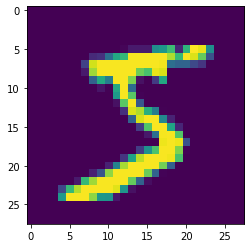

In [8]:
plt.imshow(numpy_img);

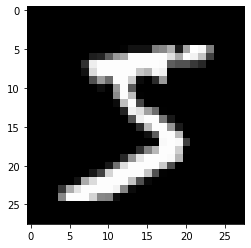

In [9]:
plt.imshow(numpy_img, cmap='gray');

Отрисовка заданной цифры:

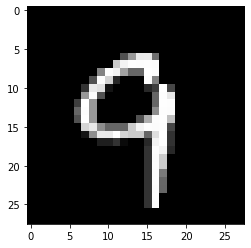

In [10]:
# случайный индекс от 0 до размера тренировочной выборки
i = np.random.randint(low=0, high=60000)

plt.imshow(trainloader.dataset.train_data[i].numpy(), cmap='gray');

Как итерироваться по данным с помощью `loader'`а? Очень просто:

In [11]:
for data in trainloader:
    print(data)
    break

[tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
   

То есть мы имеем дело с кусочками данных размера batch_size (в данном случае = 4), причём в каждом батче есть как объекты, так и ответы на них (то есть и $X$, и $y$).

Теперь вернёмся к тому, что в PyTorch есть две "парадигмы" построения нейросетей -- `Functional` и `Seuquential`. Со второй мы уже хорошенько разобрались в предыдущих ноутбуках по нейросетям, теперь мы испольузем именно `Functional` парадигму, потому что при построении свёрточных сетей это намного удобнее:

In [12]:
import torch.nn as nn
import torch.nn.functional as F  # Functional

In [13]:
# ЗАМЕТЬТЕ: КЛАСС НАСЛЕДУЕТСЯ ОТ nn.Module
class SimpleConvNet(nn.Module):
    def __init__(self):
        # вызов конструктора предка
        super(SimpleConvNet, self).__init__()
        # необходмо заранее знать, сколько каналов у картинки (сейчас = 1),
        # которую будем подавать в сеть, больше ничего
        # про входящие картинки знать не нужно
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(4 * 4 * 16, 120)  # !!!
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # print(x.shape)
        x = x.view(-1, 4 * 4 * 16)  # !!!
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

**Важное примечание:** Вы можете заметить, что в строчках с `#!!!` есть не очень понятный сходу 4 `*` 4 `*` 16. Это -- размерность картинки перед FC-слоями (H x W x C), тут её приходиться высчитывать вручную (в Keras, например, `.Flatten()` всё делает за Вас). Однако есть один *лайфхак* -- просто сделайте в `forward()` `print(x.shape)` (закомментированная строка). Вы увидите размер `(batch_size, C, H, W)` -- нужно перемножить все, кроме первого (batch_size), это и будет первая размерность `Linear()`, и именно в C * H * W нужно "развернуть" x перед подачей в `Linear()`.  

То есть нужно будет запустить цикл с обучением первый раз с `print()` и сделать после него `break`, посчитать размер, вписать его в нужные места и стереть `print()` и `break`.

Код обучения слоя:

In [14]:
from tqdm import tqdm_notebook

In [15]:
# объявляем сеть
net = SimpleConvNet()

# выбираем функцию потерь
loss_fn = torch.nn.CrossEntropyLoss()

# выбираем алгоритм оптимизации и learning_rate
learning_rate = 1e-4
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

# итерируемся
for epoch in tqdm_notebook(range(3)):

    running_loss = 0.0
    for i, batch in enumerate(tqdm_notebook(trainloader)):
        # так получаем текущий батч
        X_batch, y_batch = batch
        
        # обнуляем веса
        optimizer.zero_grad()

        # forward + backward + optimize
        y_pred = net(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        # выведем текущий loss
        running_loss += loss.item()
        # выведем качество каждые 2000 батчей
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Обучение закончено')

[1,  2000] loss: 0.968
[1,  4000] loss: 0.403
[1,  6000] loss: 0.332
[1,  8000] loss: 0.267
[1, 10000] loss: 0.227
[1, 12000] loss: 0.194
[1, 14000] loss: 0.163



[2,  2000] loss: 0.153
[2,  4000] loss: 0.140
[2,  6000] loss: 0.124
[2,  8000] loss: 0.108
[2, 10000] loss: 0.118
[2, 12000] loss: 0.107
[2, 14000] loss: 0.088



[3,  2000] loss: 0.088
[3,  4000] loss: 0.089
[3,  6000] loss: 0.087
[3,  8000] loss: 0.083
[3, 10000] loss: 0.086
[3, 12000] loss: 0.087
[3, 14000] loss: 0.071


Обучение закончено


Протестируем на всём тестовом датасете, используя метрику accuracy_score:

In [16]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        y_pred = net(images)
        _, predicted = torch.max(y_pred, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

ob = 0
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
    ob = ob + 100 * class_correct[i] / class_total[i]
print ('Accuracy: %2d %%' % ( ob / 10))

Accuracy of     0 : 98 %
Accuracy of     1 : 99 %
Accuracy of     2 : 95 %
Accuracy of     3 : 98 %
Accuracy of     4 : 96 %
Accuracy of     5 : 98 %
Accuracy of     6 : 97 %
Accuracy of     7 : 98 %
Accuracy of     8 : 94 %
Accuracy of     9 : 98 %
Accuracy: 97 %


Два свёрточных слоя побили многослойную нейросеть. Не магия ли?

---

<h1>Контрольная работа №1</h1>

Задание №1

Протестируйте эту нейросеть на отдельных картинках из тестового датасета: напишите функцию, которая принимает индекс картинки в тестовом датасете, отрисовывает её, потом запускает на ней модель (нейросеть) и выводит результат предсказания.

# <p style="color:red">Функция для предсказания картинки из тестового датасета по индексу</p>

In [17]:
def my(i):
    label = 0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    plt.imshow(testloader.dataset.data[i].numpy(), cmap='gray');
    ii = 0
    if i < 4:
        s = 0
        m = i
    else:
        s = int(i / 4)
        m = i % 4
    with torch.no_grad():
        for data in testloader:
            if ii == s:
                images, labels = data
                y_pred = net(images)
                _, predicted = torch.max(y_pred, 1)
                c = (predicted == labels).squeeze()
                label = labels[m]
                class_correct[label] += c[m].item()
                class_total[label] += 1
            ii = ii + 1

    for i in range(10):
        if (class_total[i] !=0):
            print('Accuracy of %5s : %2d %%' % (
                classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of     9 : 100 %


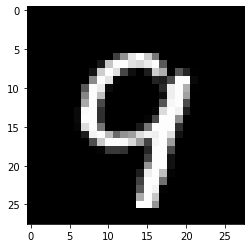

In [18]:
my(16)

---

<h3 style="text-align: center;"><b>CIFAR10</b></h3>

<img src="https://raw.githubusercontent.com/soumith/ex/gh-pages/assets/cifar10.png" width=500, height=400>

**CIFAR10:** это набор из 60k картинок 32х32х3, 50k которых составляют обучающую выборку, и оставшиеся 10k - тестовую. Классов в этом датасете 10: `'plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'`.

Скачаем и загрузим в `loader`'ы:

**Обратите внимание на аргумент `batch_size`:** именн он будет отвечать за размер батча, который будет подаваться при оптимизации нейросети

In [19]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


# <p style="color:red">Ч/Б изображение</p>

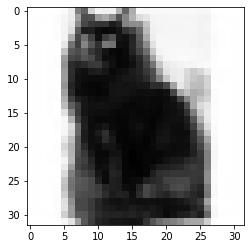

In [26]:
# случайный индекс от 0 до размера тренировочной выборки
i = np.random.randint(low=0, high=50000)

plt.imshow(trainloader.dataset.data[i][:,:,0], cmap='gray');

То есть мы имеем дело с кусочками данных размера batch_size (в данном случае = 4), причём в каждом батче есть как объекты, так и ответы на них (то есть и $X$, и $y$).

Данные готовы, мы даже на них посмотрели. **Однако учтите** - при подаче в нейросеть мы будем разворачивать картинку 32х32х3 в строку 1х(32`*`32`*`3) = 1х3072, то есть мы считаем пиксели (значения интенсивности в пикселях) за признаки нашего объекта (картинки).  

К делу:

### Задача 2

Напишите свою свёрточную нейросеть для предсказания на CIFAR10.

In [21]:
import torch
import torchvision
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt  # для отрисовки картиночек
%matplotlib inline

In [22]:
trainloader.dataset.data.shape

(50000, 32, 32, 3)

In [23]:
testloader.dataset.data.shape

(10000, 32, 32, 3)

In [24]:
numpy_img = trainloader.dataset.data[0]

In [25]:
numpy_img.shape

(32, 32, 3)

In [27]:
import torch.nn as nn
import torch.nn.functional as F 

# <p style="color:red">Архитектура сети</p>

In [28]:
class SimpleConvNet(nn.Module):
    def __init__(self):
        # вызов конструктора предка
        super(SimpleConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(5 * 16 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 5 * 5 * 16)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Обучим:

In [29]:
from tqdm import tqdm_notebook

In [30]:
loss_train = []  # для построения графиков
loss_test = []   # для построения графиков

# объявляем сеть
net = SimpleConvNet()
# выбираем функцию потерь
loss_fn = torch.nn.CrossEntropyLoss()

# выбираем алгоритм оптимизации и learning_rate
learning_rate = 1e-4
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

# итерируемся
for epoch in tqdm_notebook(range(3)):  

    running_loss = 0.0
    for i, batch in enumerate(tqdm_notebook(trainloader)):   # для train
        X_batch, y_batch = batch
        optimizer.zero_grad()
        y_pred = net(X_batch[:,2:])
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 2000 == 1999:
            loss_train.append(running_loss/2000)
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

    running_loss = 0.0
    for i, batch in enumerate(tqdm_notebook(testloader)):  # для теста
        X_batch, y_batch = batch
        optimizer.zero_grad()
        y_pred = net(X_batch[:,2:])
        loss = loss_fn(y_pred, y_batch)
        running_loss += loss.item()
        if i % 400 == 399:
            loss_test.append(running_loss/400)
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 400))
            running_loss = 0.0
print('Обучение закончено')

[1,  2000] loss: 2.116
[1,  4000] loss: 1.968
[1,  6000] loss: 1.867
[1,  8000] loss: 1.809
[1, 10000] loss: 1.768
[1, 12000] loss: 1.731



[1,   400] loss: 1.694
[1,   800] loss: 1.698
[1,  1200] loss: 1.695
[1,  1600] loss: 1.695
[1,  2000] loss: 1.696
[1,  2400] loss: 1.709



[2,  2000] loss: 1.700
[2,  4000] loss: 1.671
[2,  6000] loss: 1.662
[2,  8000] loss: 1.643
[2, 10000] loss: 1.643
[2, 12000] loss: 1.616



[2,   400] loss: 1.585
[2,   800] loss: 1.601
[2,  1200] loss: 1.599
[2,  1600] loss: 1.605
[2,  2000] loss: 1.603
[2,  2400] loss: 1.604



[3,  2000] loss: 1.607
[3,  4000] loss: 1.591
[3,  6000] loss: 1.586
[3,  8000] loss: 1.542
[3, 10000] loss: 1.534
[3, 12000] loss: 1.539



[3,   400] loss: 1.513
[3,   800] loss: 1.540
[3,  1200] loss: 1.520
[3,  1600] loss: 1.531
[3,  2000] loss: 1.545
[3,  2400] loss: 1.553


Обучение закончено


Посмотрим на accuracy на тестовом датасете:

In [31]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
p = 0
with torch.no_grad():
    for data in testloader:
        p = p + 1
        images, labels = data
        y_pred = net(images[:,2:])
        _, predicted = torch.max(y_pred, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


ob = 0
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
    ob = ob + 100 * class_correct[i] / class_total[i]
print('Accuracy: {:.2f}%'.format(ob / 10))

Accuracy of plane : 51 %
Accuracy of   car : 51 %
Accuracy of  bird : 24 %
Accuracy of   cat : 29 %
Accuracy of  deer : 48 %
Accuracy of   dog : 43 %
Accuracy of  frog : 51 %
Accuracy of horse : 54 %
Accuracy of  ship : 47 %
Accuracy of truck : 52 %
Accuracy: 45.36%


# <p style="color:red">Получилось плохо. Построим графики</p>

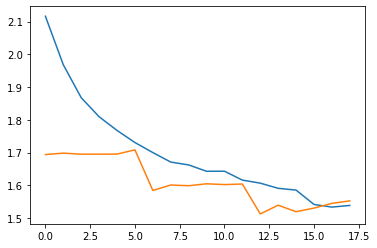

In [32]:
plt.plot(loss_train)
plt.plot(loss_test)

Как думаете, этого достаточно?

### Задача 3  

Улучшите свёрточную нейросеть: поэкспериментируйте с архитектурой (количество слоёв, порядок слоёв), с гиперпараметрами слоёв (размеры kernel_size, размеры pooling'а, количество kernel'ов в свёрточном слое) и с гиперпараметрами, указанными в "Компоненты нейросети" (см. памятку выше).

# <p style="color:red">Новая архитектура сети</p>

In [34]:
# ЗАМЕТЬТЕ: КЛАСС НАСЛЕДУЕТСЯ ОТ nn.Module
class SimpleConvNet(nn.Module):
    def __init__(self):
        # вызов конструктора предка
        super(SimpleConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=50, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=50, out_channels=150, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=150, out_channels=300, kernel_size=3)
        self.fc1 = nn.Linear(2 * 300 * 2, 100)
        self.fc2 = nn.Linear(100, 200)
        self.fc3 = nn.Linear(200, 10)
        self.norm6 = nn.BatchNorm2d(50)
        self.norm30 = nn.BatchNorm2d(30)
        self.norm70 = nn.BatchNorm2d(300)
        
    def forward(self, x):            
        x = self.pool(F.relu(self.norm6(self.conv1(x))))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.norm70(self.conv3(x))))
        x = x.view(-1, 2 * 2 * 300)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [35]:
loss_train = []  # для построения графиков
loss_test = []   # для построения графико

# объявляем сеть
net = SimpleConvNet()

# выбираем функцию потерь
loss_fn = torch.nn.CrossEntropyLoss()

# выбираем алгоритм оптимизации и learning_rate
learning_rate = 1e-4
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

# итерируемся
for epoch in tqdm_notebook(range(4)):  

    running_loss = 0.0
    for i, batch in enumerate(tqdm_notebook(trainloader)):   # для train
        X_batch, y_batch = batch
        optimizer.zero_grad()
        y_pred = net(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 2000 == 1999:
            loss_train.append(running_loss/2000)
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

    running_loss = 0.0
    for i, batch in enumerate(tqdm_notebook(testloader)):  # для теста
        X_batch, y_batch = batch
        optimizer.zero_grad()
        y_pred = net(X_batch)
        loss = loss_fn(y_pred, y_batch)
        running_loss += loss.item()
        if i % 400 == 399:
            loss_test.append(running_loss/400)
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 400))
            running_loss = 0.0

print('Обучение закончено')

[1,  2000] loss: 1.753
[1,  4000] loss: 1.434
[1,  6000] loss: 1.332
[1,  8000] loss: 1.234
[1, 10000] loss: 1.177
[1, 12000] loss: 1.139



[1,   400] loss: 1.127
[1,   800] loss: 1.148
[1,  1200] loss: 1.079
[1,  1600] loss: 1.127
[1,  2000] loss: 1.126
[1,  2400] loss: 1.151



[2,  2000] loss: 1.025
[2,  4000] loss: 1.008
[2,  6000] loss: 0.982
[2,  8000] loss: 0.963
[2, 10000] loss: 0.934
[2, 12000] loss: 0.936



[2,   400] loss: 0.954
[2,   800] loss: 0.995
[2,  1200] loss: 0.937
[2,  1600] loss: 0.969
[2,  2000] loss: 0.967
[2,  2400] loss: 0.995



[3,  2000] loss: 0.837
[3,  4000] loss: 0.815
[3,  6000] loss: 0.803
[3,  8000] loss: 0.810
[3, 10000] loss: 0.788
[3, 12000] loss: 0.804



[3,   400] loss: 0.882
[3,   800] loss: 0.933
[3,  1200] loss: 0.888
[3,  1600] loss: 0.899
[3,  2000] loss: 0.888
[3,  2400] loss: 0.924



[4,  2000] loss: 0.673
[4,  4000] loss: 0.663
[4,  6000] loss: 0.687
[4,  8000] loss: 0.686
[4, 10000] loss: 0.679
[4, 12000] loss: 0.697



[4,   400] loss: 0.847
[4,   800] loss: 0.906
[4,  1200] loss: 0.852
[4,  1600] loss: 0.885
[4,  2000] loss: 0.860
[4,  2400] loss: 0.904


Обучение закончено


In [36]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        y_pred = net(images)
        _, predicted = torch.max(y_pred, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

ob = 0
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
    ob = ob + 100 * class_correct[i] / class_total[i]
print('Accuracy: {:.2f}%'.format(ob / 10))

Accuracy of plane : 71 %
Accuracy of   car : 88 %
Accuracy of  bird : 54 %
Accuracy of   cat : 57 %
Accuracy of  deer : 80 %
Accuracy of   dog : 49 %
Accuracy of  frog : 70 %
Accuracy of horse : 72 %
Accuracy of  ship : 75 %
Accuracy of truck : 81 %
Accuracy: 70.11%


# <p style="color:red">Построим графики:</p>

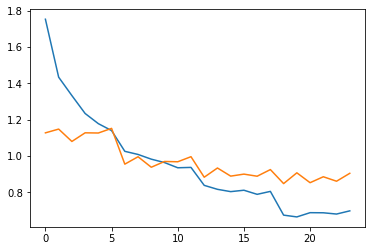

In [37]:
plt.plot(loss_train)
plt.plot(loss_test)

# <p style="color:red">Полученный результат: 70.11%</p>

# <p style="color:red">Удалось услучшить так:</p>
 <p style="color:red">– увеличила количество нейронов во всех слоях</p>
 <p style="color:red">– добавила дополнительный сверточный слой</p>
 <p style="color:red">– увеличила количество эпох</p>
 <p style="color:red">– добавила нормализацию</p>

(Ожидаемый результат -- скорее всего, сходу Вам не удастся выжать из Вашей сетки больше, чем ~70% accuracy (в среднем по всем классам). Если это что-то в этом районе - Вы хорошо постарались).

<h3 style="text-align: center;"><b>Полезные ссылки</b></h3>

1). *Примеры написания нейросетей на PyTorch (офийиальные туториалы) (на английском): https://pytorch.org/tutorials/beginner/pytorch_with_examples.html#examples  
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html*

2). ***Один из самых подробных и полных курсов по deep learning на данный момент - это курс Стэнфордского Университета (он вообще сейчас один из лидеров в области ИИ, его выпускники работают в Google, Facebook, Amazon, Microsoft, в стартапах в Кремниевой долине):  http://cs231n.github.io/***  

3). Практически исчерпывающая информация по основам свёрточных нейросетей (из cs231n) (на английском):  

http://cs231n.github.io/convolutional-networks/  
http://cs231n.github.io/understanding-cnn/  
http://cs231n.github.io/transfer-learning/

4). Видео о Computer Vision от Andrej Karpathy: https://www.youtube.com/watch?v=u6aEYuemt0M